# Batching across material parameters

In the previous section, we focused on batching over applied strain and internal state variables, assuming fixed material properties. Here, we extend this idea to batch across **material parameters** as well, which is useful when studying the effect of uncertainty or variability in material behavior.

We return to our initial elastoplastic material with Voce hardening. Our goal is to investigate how variations in the hardening parameters affect the response under a monotonous shear loading. In this example, we consider the response of a single physical point, but by sampling $N$ independent realizations of the material parameters, we effectively compute the response of a batch of $N$ stochastic material points.

In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import equinox as eqx
import jaxmat.materials as jm
import matplotlib.pyplot as plt
from jaxmat.tensors import SymmetricTensor2
from jaxmat.state import make_batched


class VoceHardening(eqx.Module):
    sig0: float = eqx.field(converter=jnp.asarray)
    sigu: float = eqx.field(converter=jnp.asarray)
    b: float = eqx.field(converter=jnp.asarray)

    def __call__(self, p):
        return self.sig0 + (self.sigu - self.sig0) * (1 - jnp.exp(-self.b * p))


elasticity = jm.LinearElasticIsotropic(E=200e3, nu=0.25)
hardening = VoceHardening(sig0=350.0, sigu=500.0, b=1e3)

material = jm.vonMisesIsotropicHardening(elasticity=elasticity, yield_stress=hardening)

print("A single material instance:", material)

A single material instance: vonMisesIsotropicHardening(
  internal_type=jaxmat.materials.elastoplasticity.InternalState,
  elasticity=LinearElasticIsotropic(E=f64[], nu=f64[]),
  yield_stress=VoceHardening(sig0=weak_f64[], sigu=weak_f64[], b=weak_f64[])
)


To simulate variability in material behavior, we generate $N$ stochastic realizations of the hardening parameter $b$. We use a log-normal distribution to introduce small random variations around a nominal value of $b=10^3$. `sorting` will be used later to order the realizations for consistent plotting.

In [2]:
key = jax.random.PRNGKey(42)
N = 100
b_values = 10 ** (3 * jax.random.lognormal(key, sigma=0.05, shape=(N,)))
sorting = jnp.argsort(b_values)

Finally, we convert our single material instance into a batched material where `make_batched` replicates the material PyTree $N$ times along a new batch axis. `eqx.tree_at` updates the $b$ parameter in each instance with the sampled stochastic values.
The resulting `batched_material` is a PyTree containing $N$ distinct material instances, ready for vectorized constitutive updates.

In [3]:
batched_material = make_batched(material, N)
batched_material = eqx.tree_at(lambda m: m.yield_stress.b, batched_material, b_values)
print(f"A batch of {N} material instances:", batched_material)

A batch of 100 material instances: vonMisesIsotropicHardening(
  _batch_size=(100,),
  internal_type=jaxmat.materials.elastoplasticity.InternalState,
  elasticity=LinearElasticIsotropic(E=f64[100], nu=f64[100]),
  yield_stress=VoceHardening(sig0=weak_f64[100], sigu=weak_f64[100], b=f64[100]),
  plastic_surface=vonMises()
)


Next, we initialize the state for all stochastic material points and apply a simple monotonous shear loading. We use `eqx.filter_vmap` to vectorize the constitutive update over the batch of materials, while keeping the applied strain and time step fixed. The resulting shear stresses are stored for each realization.

In [4]:
state = batched_material.init_state()
gamma_list = jnp.linspace(0.0, 1e-2, 50)
tau = jnp.zeros((N, len(gamma_list)))

for i, gamma in enumerate(gamma_list):
    # Define shear strain tensor
    new_eps = jnp.array([[0, gamma / 2, 0], [gamma / 2, 0, 0], [0, 0, 0]])
    new_eps = SymmetricTensor2(tensor=new_eps)

    # Compute batch stress update
    new_stress, new_state = eqx.filter_vmap(
        jm.vonMisesIsotropicHardening.constitutive_update, in_axes=(0, None, 0, None)
    )(batched_material, new_eps, state, 0.0)

    state = new_state
    tau = tau.at[:, i].set(new_stress[:, 0, 1])

```{note}
`filter_vmap` from `equinox` is used instead of `vmap` because it can handle PyTrees, such as `equinox` material modules, whereas `vmap` only works with simple arrays. It vectorizes the parts of the PyTree that are batched while keeping constant or static components unchanged. This allows us to efficiently compute a batch of material instances with different parameters while reusing the same strain and time step across the batch.
```

Finally, we visualize the results. Each line represents the shear response of one stochastic material realization. The mean response is plotted in black, with the standard deviation shown as error bars to highlight the variability due to uncertain hardening parameters.

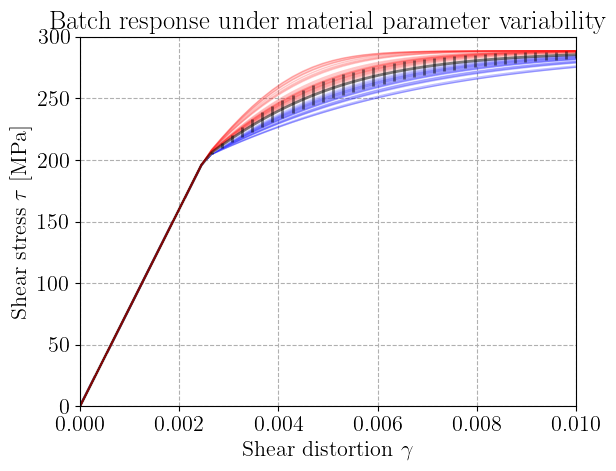

In [5]:
cmap = plt.get_cmap("bwr")
colors = cmap(jnp.linspace(0, 1, N))

for i, color in enumerate(colors):
    plt.plot(gamma_list, tau[sorting[i], :].T, linewidth=1.0, alpha=0.25, color=color)

plt.errorbar(
    gamma_list, jnp.mean(tau, axis=0), jnp.std(tau, axis=0), color="k", alpha=0.5
)
plt.xlabel(r"Shear distortion $\gamma$")
plt.ylabel(r"Shear stress $\tau$ [MPa]")
plt.title("Batch response under material parameter variability")
plt.show()